In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os
import collections
from collections import defaultdict
from shutil import copy
from shutil import copytree, rmtree
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from tqdm import tqdm


In [2]:
os.listdir('food-101/food-101/')

['test', 'README.txt', 'train', 'meta', 'images', 'train_mini', 'test_mini']

In [3]:
src_train = 'food-101/food-101/train'
src_test = 'food-101/food-101/test'
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [4]:

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),#ImageNetPolicy(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(src_train, transform=train_transforms)
test_data = datasets.ImageFolder(src_test, transform=test_transforms)
testdata=datasets.ImageFolder(src_test, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=128)

In [5]:
len(trainloader)

592

In [6]:
model =models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
for param in model.parameters():
    param.requires_grad = True

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 101)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [8]:
import time

In [9]:
for device in ['cuda:1']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")


Device = cuda:1; Time per batch: 0.008 seconds


In [10]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#training the full model
for param in model.parameters():
    param.requires_grad = True

model.classifier = nn.Sequential(nn.Linear(1024,512),nn.LeakyReLU(),nn.Linear(512,256),nn.LeakyReLU(),nn.Linear(256,101))

criterion = nn.CrossEntropyLoss()

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, betas=[0.9, 0.999])

In [13]:
import numpy as np
import time
def train(n_epochs,trainloader,testloader, resnet, optimizer, criterion, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    running_loss=0
    train_loss = []
    val_loss = []
    accu = []
    val_accu = []
  
    for epoch in range(n_epochs):
        start_epoch = time.time()
        
        train_accuracy = 0
        for inputs, labels in tqdm(trainloader):
            
        # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            start = time.time()
            logps = resnet(inputs)
            loss = criterion(logps, labels)
            top_p, top_class = logps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            
#             if(True):
#                 break
        train_loss.append(running_loss/len(trainloader))
        accu.append(train_accuracy/len(trainloader))
        
        resnet.eval()
        valid_loss=0
        valid_accuracy=0
        with torch.no_grad():
            for inputs, labels in tqdm(testloader):
                inputs, labels = inputs.to(device), labels.to(device)
                logps = resnet(inputs)
                batch_loss = criterion(logps, labels)
                valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                
                top_p, top_class = logps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
            if valid_loss <= valid_loss_min:
                print("Validation loss decreased  Saving model")
                torch.save(resnet.state_dict(),'food_classifier_resnet18.pt')
                valid_loss_min=valid_loss
                
                    
                
                  
                
                
                   
            val_loss.append(valid_loss/len(testloader))
            val_accu.append(valid_accuracy/len(testloader))
            
            print(f"Device = cuda; Time per batch: {(time.time() - start):.3f} seconds")       
            print(f"Device = cuda; Time per epoch: {(time.time() - start_epoch)/60:.3f} minutes")       
            print(f"Epoch {epoch}/{n_epochs}.. "
                  f"Train loss: {running_loss/len(trainloader):.3f}.. "
                  f"Test loss: {valid_loss/len(testloader):.3f}.. "
                  f"Train accuracy: {train_accuracy/len(trainloader):.3f}.."
                  f"Test accuracy: {valid_accuracy/len(testloader):.3f}")
            running_loss = 0
            resnet.train()
    return train_loss, val_loss, accu, val_accu

In [14]:
train_loss, val_loss, accu, val_accu = train(30, trainloader, testloader, model, optimizer, criterion,'model_vowel_consonant.pt')

  0%|          | 0/592 [00:00<?, ?it/s]

Validation loss decreased  Saving model
Device = cuda; Time per batch: 206.433 seconds
Device = cuda; Time per epoch: 14.646 minutes
Epoch 0/30.. Train loss: 2.847.. Test loss: 1.941.. Train accuracy: 0.329..Test accuracy: 0.496


  0%|          | 0/592 [00:00<?, ?it/s]

Validation loss decreased  Saving model
Device = cuda; Time per batch: 208.686 seconds
Device = cuda; Time per epoch: 15.619 minutes
Epoch 1/30.. Train loss: 2.098.. Test loss: 1.595.. Train accuracy: 0.479..Test accuracy: 0.579


  0%|          | 0/592 [00:00<?, ?it/s]

Validation loss decreased  Saving model
Device = cuda; Time per batch: 207.222 seconds
Device = cuda; Time per epoch: 14.660 minutes
Epoch 2/30.. Train loss: 1.853.. Test loss: 1.316.. Train accuracy: 0.533..Test accuracy: 0.649


  0%|          | 0/592 [00:00<?, ?it/s]

Validation loss decreased  Saving model
Device = cuda; Time per batch: 259.600 seconds
Device = cuda; Time per epoch: 15.469 minutes
Epoch 3/30.. Train loss: 1.721.. Test loss: 1.163.. Train accuracy: 0.564..Test accuracy: 0.689


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 208.048 seconds
Device = cuda; Time per epoch: 14.607 minutes
Epoch 4/30.. Train loss: 1.610.. Test loss: 1.224.. Train accuracy: 0.591..Test accuracy: 0.677


  0%|          | 0/592 [00:00<?, ?it/s]

Validation loss decreased  Saving model
Device = cuda; Time per batch: 209.870 seconds
Device = cuda; Time per epoch: 14.718 minutes
Epoch 5/30.. Train loss: 1.532.. Test loss: 1.049.. Train accuracy: 0.611..Test accuracy: 0.717


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 177.014 seconds
Device = cuda; Time per epoch: 13.500 minutes
Epoch 6/30.. Train loss: 1.460.. Test loss: 1.068.. Train accuracy: 0.626..Test accuracy: 0.709


  0%|          | 0/592 [00:00<?, ?it/s]

Validation loss decreased  Saving model
Device = cuda; Time per batch: 186.650 seconds
Device = cuda; Time per epoch: 12.759 minutes
Epoch 7/30.. Train loss: 1.404.. Test loss: 0.990.. Train accuracy: 0.640..Test accuracy: 0.735


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 177.548 seconds
Device = cuda; Time per epoch: 12.586 minutes
Epoch 8/30.. Train loss: 1.356.. Test loss: 1.015.. Train accuracy: 0.651..Test accuracy: 0.726


  0%|          | 0/592 [00:00<?, ?it/s]

Validation loss decreased  Saving model
Device = cuda; Time per batch: 177.158 seconds
Device = cuda; Time per epoch: 12.728 minutes
Epoch 9/30.. Train loss: 1.307.. Test loss: 0.980.. Train accuracy: 0.662..Test accuracy: 0.737


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 185.077 seconds
Device = cuda; Time per epoch: 12.763 minutes
Epoch 10/30.. Train loss: 1.256.. Test loss: 0.985.. Train accuracy: 0.672..Test accuracy: 0.737


  0%|          | 0/592 [00:00<?, ?it/s]

Validation loss decreased  Saving model
Device = cuda; Time per batch: 177.467 seconds
Device = cuda; Time per epoch: 12.255 minutes
Epoch 11/30.. Train loss: 1.219.. Test loss: 0.977.. Train accuracy: 0.683..Test accuracy: 0.738


  0%|          | 0/592 [00:00<?, ?it/s]

Validation loss decreased  Saving model
Device = cuda; Time per batch: 182.753 seconds
Device = cuda; Time per epoch: 12.632 minutes
Epoch 12/30.. Train loss: 1.186.. Test loss: 0.907.. Train accuracy: 0.688..Test accuracy: 0.754


  0%|          | 0/592 [00:00<?, ?it/s]

Validation loss decreased  Saving model
Device = cuda; Time per batch: 179.166 seconds
Device = cuda; Time per epoch: 12.539 minutes
Epoch 13/30.. Train loss: 1.155.. Test loss: 0.898.. Train accuracy: 0.697..Test accuracy: 0.758


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 180.411 seconds
Device = cuda; Time per epoch: 12.641 minutes
Epoch 14/30.. Train loss: 1.114.. Test loss: 0.946.. Train accuracy: 0.706..Test accuracy: 0.753


  0%|          | 0/592 [00:00<?, ?it/s]

Validation loss decreased  Saving model
Device = cuda; Time per batch: 150.264 seconds
Device = cuda; Time per epoch: 11.521 minutes
Epoch 15/30.. Train loss: 1.090.. Test loss: 0.881.. Train accuracy: 0.712..Test accuracy: 0.766


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 150.530 seconds
Device = cuda; Time per epoch: 10.740 minutes
Epoch 16/30.. Train loss: 1.065.. Test loss: 0.926.. Train accuracy: 0.718..Test accuracy: 0.755


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 183.810 seconds
Device = cuda; Time per epoch: 11.704 minutes
Epoch 17/30.. Train loss: 1.037.. Test loss: 0.909.. Train accuracy: 0.725..Test accuracy: 0.762


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 184.350 seconds
Device = cuda; Time per epoch: 12.961 minutes
Epoch 18/30.. Train loss: 1.014.. Test loss: 0.921.. Train accuracy: 0.730..Test accuracy: 0.763


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 183.789 seconds
Device = cuda; Time per epoch: 13.014 minutes
Epoch 19/30.. Train loss: 0.988.. Test loss: 0.892.. Train accuracy: 0.736..Test accuracy: 0.769


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 185.109 seconds
Device = cuda; Time per epoch: 12.986 minutes
Epoch 20/30.. Train loss: 0.958.. Test loss: 0.909.. Train accuracy: 0.745..Test accuracy: 0.764


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 185.244 seconds
Device = cuda; Time per epoch: 12.977 minutes
Epoch 21/30.. Train loss: 0.940.. Test loss: 0.907.. Train accuracy: 0.748..Test accuracy: 0.771


  0%|          | 0/592 [00:00<?, ?it/s]

Validation loss decreased  Saving model
Device = cuda; Time per batch: 185.061 seconds
Device = cuda; Time per epoch: 12.960 minutes
Epoch 22/30.. Train loss: 0.916.. Test loss: 0.878.. Train accuracy: 0.753..Test accuracy: 0.771


  0%|          | 0/592 [00:00<?, ?it/s]

Validation loss decreased  Saving model
Device = cuda; Time per batch: 184.013 seconds
Device = cuda; Time per epoch: 13.079 minutes
Epoch 23/30.. Train loss: 0.904.. Test loss: 0.860.. Train accuracy: 0.758..Test accuracy: 0.779


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 189.344 seconds
Device = cuda; Time per epoch: 13.140 minutes
Epoch 24/30.. Train loss: 0.883.. Test loss: 0.897.. Train accuracy: 0.762..Test accuracy: 0.772


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 185.245 seconds
Device = cuda; Time per epoch: 12.967 minutes
Epoch 25/30.. Train loss: 0.862.. Test loss: 0.865.. Train accuracy: 0.766..Test accuracy: 0.776


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 185.287 seconds
Device = cuda; Time per epoch: 13.010 minutes
Epoch 26/30.. Train loss: 0.840.. Test loss: 0.900.. Train accuracy: 0.773..Test accuracy: 0.773


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 185.017 seconds
Device = cuda; Time per epoch: 13.076 minutes
Epoch 27/30.. Train loss: 0.821.. Test loss: 0.862.. Train accuracy: 0.778..Test accuracy: 0.783


  0%|          | 0/592 [00:00<?, ?it/s]

Device = cuda; Time per batch: 184.375 seconds
Device = cuda; Time per epoch: 12.995 minutes
Epoch 28/30.. Train loss: 0.812.. Test loss: 0.920.. Train accuracy: 0.780..Test accuracy: 0.769


100%|██████████| 198/198 [03:05<00:00,  1.07it/s]

Device = cuda; Time per batch: 185.431 seconds
Device = cuda; Time per epoch: 13.021 minutes
Epoch 29/30.. Train loss: 0.799.. Test loss: 0.929.. Train accuracy: 0.785..Test accuracy: 0.772


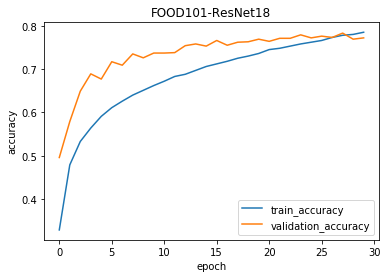

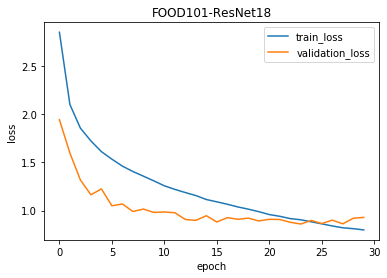

In [15]:
def plot_accuracy(val_acc, train_acc, title):
    plt.title(title)
    plt.plot(train_acc) 
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(val_loss, train_loss, title):
    plt.title(title)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(val_accu, accu, 'FOOD101-ResNet18')
plot_loss(val_loss, train_loss, 'FOOD101-ResNet18')